# --- COMPTAGE DE DOIGTS A PARTIR D'UN MASQUE DE MAINS ---
#### Développons une technique de computer vision répondant au cahier des charges suivant:
#### - input: une image noir et blanc où le blanc représente les zones d'intérêt où des mains se trouvent sur l'image*
#### - output: un dénombrement du nombre de doigts montré par chaque main

## Environnement

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
import math

if( '../modules' in sys.path):
    sys.path.remove('../modules')
sys.path.insert(1, '../modules')

from skin_detection_generic import *
from skin_detection_specific import *
from utils import *

## Input

In [11]:
#IMAGE_PATH = '../data/skin_detection_color/African-stock-video-of-black-man-hands-typing-on-a-laptop-computer.jpg'
IMAGE_PATH = '../data/first dataset/0.png'

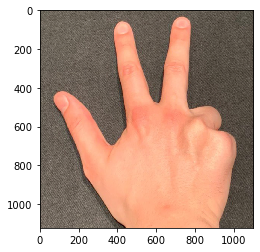

In [12]:
raw_image = load_and_show_rgb_image(IMAGE_PATH)

Masque filtrant la peau


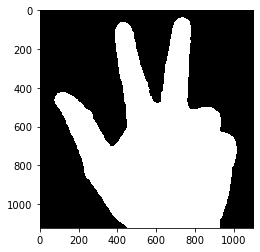

In [13]:
filtered_image, skin_mask = skin_detection_specific(raw_image)
print('Masque filtrant la peau')
plt.imshow(skin_mask, cmap='gray')

In [14]:
LINE_WIDTH = 5 + int(raw_image.shape[1] / 150)
PT_RADIUS = LINE_WIDTH * 2

## COMPTEUR DE DOIGTS: 1) Détection des contours de chaque main

In [15]:
def keepBiggestContours(contours):
    """Filter the contours to keep the biggest ones"""
    
    # Detect the max number of points and the largest area
    maxIndex = 0
    maxArea = 0
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area > maxArea:
            maxArea = area
    
    # Keep all contours with nb of points > maxIndex an areas > 0.5 * maxArea
    keep_indexes = []            
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if(area > maxArea * 0.2):
            keep_indexes.append(i)        
    
    return [contours[i] for i in keep_indexes]

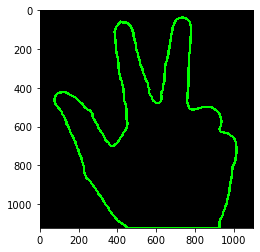

On garde les plus gros contours (dans ce cas on a gardé 1 contours)


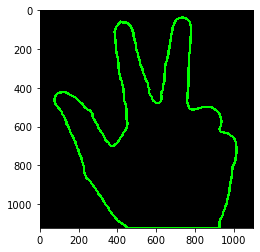

In [16]:
# On récupère le contour de chaque "île de blanc" présente dans le mask
contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)# There might be no contour when hand is not inside the frame

canvas = np.zeros_like(raw_image)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), LINE_WIDTH)
plt.imshow(canvas)
plt.pause(0.1)

# Filtrage pour ne garder que les plus gros contours
contours = keepBiggestContours(contours)

print('On garde les plus gros contours (dans ce cas on a gardé {} contours)'.format(len(contours)))
canvas = np.zeros_like(raw_image)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), LINE_WIDTH)
plt.imshow(canvas)

In [17]:
# On récupère l'enveloppe convexe de chaque contour
convHull_points = []
convHull_indexes = []
for i in range(len(contours)):
    convHull_points.append(cv2.convexHull(contours[i], returnPoints=True))
    convHull_indexes.append(cv2.convexHull(contours[i], returnPoints=False))

## COMPTEUR DE DOIGTS: 2) Enveloppe convexe brute de chaque contour

Enveloppes convexes brutes (composée de nombreux points:[36]).
En bleu: l enveloppe convexe, en rose: les points qui permettent de la tracer.


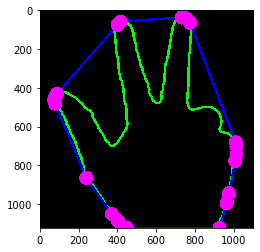

In [18]:
# On récupère l'enveloppe convexe de chaque contour
convHull_points = []
convHull_indexes = []
for i in range(len(contours)):
    convHull_points.append(cv2.convexHull(contours[i], returnPoints=True))
    convHull_indexes.append(cv2.convexHull(contours[i], returnPoints=False))

print('Enveloppes convexes brutes (composée de nombreux points:{}).'.format([len(conv) for conv in convHull_points]))
print('En bleu: l enveloppe convexe, en rose: les points qui permettent de la tracer.')
canvas = np.zeros_like(raw_image)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), LINE_WIDTH)
cv2.drawContours(canvas , convHull_points, -1, (0, 0, 255), LINE_WIDTH)
for convHull in convHull_points:
    cv2.drawContours(canvas , convHull, -1, (255, 0, 255), PT_RADIUS*3)
plt.imshow(canvas)

## COMPTEUR DE DOIGTS: 3) Enveloppe convexe filtrée de chaque contour

In [19]:
def getMinimizedConvHull(convHull):
    # Déterminer la distance minimale de séparation:
    # On détermine la largeur du contour et on applique un threshold arbitraire /10
    minX, minY, maxX, maxY = convHull[0,0][0], convHull[0,0][1], convHull[0,0][0], convHull[0,0][1]
    for point in convHull:
        X, Y = point[0][0], point[0][1]
        if X > maxX:
            maxX = X
        elif X < minX:
            minX = X
        if Y > maxY:
            maxY = Y
        elif Y < minY:
            minY = Y
    separation_dist = min(maxX-minX, maxY-minY)/10
    
    
    # On parcours une fois la liste de points pour constuire [d0, d1, ..., dn]
    distances = []
    for i in range(1, len(convHull)):
        distances.append((convHull[i,0][0]-convHull[i-1,0][0])**2 + (convHull[i,0][1]-convHull[i-1,0][1])**2)

    minimized_indexes = []
    count = 1
    for i in range(len(distances)):
        if(distances[i] > separation_dist**2):
            minimized_indexes.append(i - int(count/2))
            count = 1
        else:
            count += 1
    if count > 0:
        minimized_indexes.append(len(distances) - int(count/2))
    return minimized_indexes

Enveloppes convexes filtrées (composée du minnimum de points:[9].
En bleu: l enveloppe convexe, en rose: les points qui permettent de la tracer.


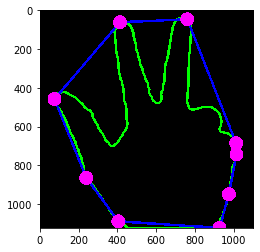

In [20]:
# On filtre les enveloppes convexes pour garder un set minimal de points formant l'enveloppe
filtered_convHull_points = []
filtered_convHull_indexes = []
for i in range(len(convHull_points)):
    filter_indexes = getMinimizedConvHull(convHull_points[i])
    filtered_convHull_points.append(convHull_points[i][filter_indexes])
    filtered_convHull_indexes.append(convHull_indexes[i][filter_indexes])

print('Enveloppes convexes filtrées (composée du minnimum de points:{}.'.format([len(conv) for conv in filtered_convHull_points]))
print('En bleu: l enveloppe convexe, en rose: les points qui permettent de la tracer.')
canvas = np.zeros_like(raw_image)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), LINE_WIDTH)
cv2.drawContours(canvas , filtered_convHull_points, -1, (0, 0, 255), LINE_WIDTH)
for convHull in filtered_convHull_points:
    cv2.drawContours(canvas , convHull, -1, (255, 0, 255), PT_RADIUS*3)
plt.imshow(canvas)

## COMPTEUR DE DOIGTS: 3) Détection des points de convexité maximaux pour chaque intervalle de points format l'enveloppe convexe

Apercu de toutes les cavités extrèmes détectées (point extrême en bleu clair et cavité remplie en jaune)


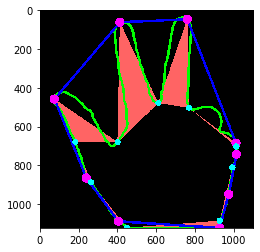

In [21]:
start_points, end_points, farthest_points, defaults, fingers = [], [], [], [], []
for i in range(len(contours)):
    convexity_defects = cv2.convexityDefects(contours[i], filtered_convHull_indexes[i])

    for defect in convexity_defects:
        s, e, f, d = defect[0]
        start = tuple(contours[i][s, 0])
        end = tuple(contours[i][e, 0])
        farthest = tuple(contours[i][f, 0])
        
        
        defaults.append([[start], [farthest], [end]])
        farthest_points.append(farthest)
        if(start not in start_points):
            start_points.append(start)
        if(end not in end_points):
            end_points.append(end)
    
    for k in range(1, len(convexity_defects)):
            s0, e0, f0, d0 = convexity_defects[k-1][0]
            s1, e1, f1, d1 = convexity_defects[k][0]
            far0 = tuple(contours[i][f0, 0])
            end0 = tuple(contours[i][e0, 0])
            far1 = tuple(contours[i][f1, 0])
            fingers.append([[far0], [end0], [far1]])
            
new_canvas = np.zeros_like(raw_image)

#for caveat in defaults:
#    cv2.drawContours(new_canvas , np.array([caveat]), -1, (255, 255, 0), -1)

for finger in fingers:
    cv2.drawContours(new_canvas , np.array([finger]), -1, (255, 100, 100), -1)

cv2.drawContours(new_canvas , contours, -1, (0, 255, 0), LINE_WIDTH)
cv2.drawContours(new_canvas , filtered_convHull_points, -1, (0, 0, 255), LINE_WIDTH)

for start in start_points:
    cv2.circle(new_canvas, start, PT_RADIUS, [255, 0, 255], -1)
for end in end_points:
    cv2.circle(new_canvas, end, PT_RADIUS, [255, 0, 255], -1)
for far in farthest_points:
    cv2.circle(new_canvas, far, int(PT_RADIUS*0.7), [0, 255, 255], -1)
#new_canvas = cv2.circle(new_canvas, end, PT_RADIUS, [255, 0, 255], -1)
#new_canvas = cv2.circle(new_canvas, farthest, PT_RADIUS*2, [0, 255, 255], 10)

print('Apercu de toutes les cavités extrèmes détectées (point extrême en bleu clair et cavité remplie en jaune)')
plt.imshow(new_canvas)

## COMPTEUR DE DOIGTS: 4) Filtrage des défauts de convexité maximaux pour déduire le nombre de doigts 

#### La méthode la plus efficace trouvée est la suivante:
- On fait une première passe pour détecter tous les creux de convexité maximaux pertinents:
    - Qui on un point maximal assez éloigné des bords de l'enveloppe convexe.
    - Dont le creux forme un angle aigü < Pi/2
    - Pour chaque creux remplissant ces conditions on rajoute les points correspondants sur l'enveloppe en tant que doigts détectés
- Si on n'a detécté aucun doigt lors de la première passe, cela signifie que la main ne montre que des doigts isolés (pas de creux bien éloigné du bord de l'enveloppe, donc on va tenter de cerner les points de l'enveloppe qui pourraient être des doigts:
    - Pour chaque point de l'enveloppe, s'il est entouré de deux défauts de convexité qui forment un angle aigü < Pi/3 alors c'est un doigt

In [22]:
def calculateAngle(pt0, pt1, pt2):
    """Cosine rule"""
    a = math.sqrt((pt2[0] - pt0[0])**2 + (pt2[1] - pt0[1])**2)
    b = math.sqrt((pt1[0] - pt0[0])**2 + (pt1[1] - pt0[1])**2)
    c = math.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
    angle = math.acos((b**2 + c**2 - a**2) / (2*b*c))
    return angle

In [23]:
def detectFingersFromHullConvex(contour, hullConvex_indexes):
    
    fingers_detected = []
    relevant_convexity_defects = []
    
    convexity_defects = cv2.convexityDefects(contour, hullConvex_indexes)
    
    # Méthode classique : compter les creux entre les doigts
    for defect in convexity_defects:
        s, e, f, d = defect[0]
        start = tuple(contour[s, 0])
        end = tuple(contour[e, 0])
        farthest = tuple(contour[f, 0])
        if(d > 10000) and calculateAngle(start, farthest, end) < 5*math.pi / 12:
            relevant_convexity_defects.append(farthest)
            if(start not in fingers_detected):
                fingers_detected.append(start)
            if(end not in fingers_detected): 
                fingers_detected.append(end)
    
    # Méthode alternative: compter les doigts directement
    if len(fingers_detected) < 1:
        for k in range(1, len(convexity_defects)):
            s0, e0, f0, d0 = convexity_defects[k-1][0]
            s1, e1, f1, d1 = convexity_defects[k][0]
            far0 = tuple(contour[f0, 0])
            end0 = tuple(contour[e0, 0])
            far1 = tuple(contour[f1, 0])
            if(calculateAngle(far0, end0, far1) < math.pi / 3):
                fingers_detected.append(end0)
                relevant_convexity_defects.append(far0)
                relevant_convexity_defects.append(far1)
                
    return fingers_detected, relevant_convexity_defects

[(758, 47), (411, 63), (74, 458)]


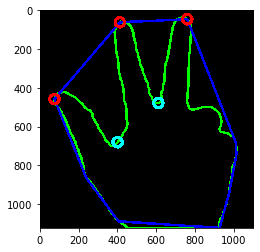

In [24]:
new_canvas = np.zeros_like(raw_image)
cv2.drawContours(new_canvas , contours, -1, (0, 255, 0), LINE_WIDTH)
cv2.drawContours(new_canvas , filtered_convHull_points, -1, (0, 0, 255), LINE_WIDTH)

for i in range(len(contours)):
    fingers_detected, relevant_convexity_defects = detectFingersFromHullConvex(contours[i], filtered_convHull_indexes[i])
    print(fingers_detected)
    
    for finger in fingers_detected:
        new_canvas = cv2.circle(new_canvas, finger, PT_RADIUS, [255, 0, 0], 15)
    for convexity_defect in relevant_convexity_defects:
        new_canvas = cv2.circle(new_canvas, convexity_defect, PT_RADIUS, [0, 255, 255], 15)  

plt.imshow(new_canvas)